In [1]:
import pandas as pd
import nltk
from sklearn import model_selection, preprocessing, linear_model, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn import decomposition, ensemble

import xgboost, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

audio_col=['avf1', 'avf2', 'avf3', 'avf4', 'avf5', 'avf6', 'avf7', 'avf8',
       'avf9', 'avf10', 'avf11', 'avf12', 'avf13', 'avf14', 'avf15',
       'avf16', 'avf17', 'avf18', 'avf19', 'avf20', 'avf21', 'avf22',
       'avf23', 'avf24', 'avf25', 'avf26', 'avf27', 'avf28', 'avf29',
       'avf30', 'avf31', 'avf32', 'avf33', 'avf34', 'avf35', 'avf36',
       'avf37', 'avf38', 'avf39', 'avf40', 'avf41', 'avf42', 'avf43',
       'avf44', 'avf45', 'avf46', 'avf47', 'avf48', 'avf49', 'avf50',
       'avf51', 'avf52', 'avf53', 'avf54', 'avf55', 'avf56', 'avf57',
       'avf58', 'avf59', 'avf60', 'avf61', 'avf62', 'avf63', 'avf64',
       'avf65', 'avf66', 'avf67', 'avf68', 'avf69', 'avf70', 'avf71',
       'avf72', 'avf73', 'avf74', 'avf75', 'avf76', 'avf77', 'avf78',
       'avf79', 'avf80', 'avf81', 'avf82', 'avf83', 'avf84', 'avf85',
       'avf86', 'avf87', 'avf88', 'avf89', 'avf90', 'avf91', 'avf92',
       'avf93', 'avf94', 'avf95', 'avf96', 'avf97', 'avf98', 'avf99',
       'avf100', 'avf101', 'avf102', 'avf103', 'avf104', 'avf105',
       'avf106', 'avf107']
visual_col=['ivec1', 'ivec2', 'ivec3', 'ivec4', 'ivec5', 'ivec6', 'ivec7',
       'ivec8', 'ivec9', 'ivec10', 'ivec11', 'ivec12', 'ivec13', 'ivec14',
       'ivec15', 'ivec16', 'ivec17', 'ivec18', 'ivec19', 'ivec20']

tf_org = pd.read_csv('data/train_features.tsv', sep = '\t')
tl_org = pd.read_csv('data/train_labels.tsv', sep = '\t')
vf_org = pd.read_csv('data/valid_features.tsv', sep = '\t')
vl_org = pd.read_csv('data/valid_labels.tsv', sep = '\t')

#drop the irrelevant features
tf_org = tf_org.drop(columns = ['year', 'YTId'])
vf_org = vf_org.drop(columns = ['year', 'YTId'])
#drop the rows which have missing values
train = pd.concat([tf_org, tl_org],axis=1)
#drop the rows with missing data
train.dropna(axis=0, how='any', inplace=True)
#tf stores the training features 
tf = train.iloc[:,:-2]
#tf stores the training labels
tl = train.iloc[:,-2:]
tf = tf.reset_index(drop=True)
tl = tl.reset_index(drop=True)
valid = pd.concat([vf_org, vl_org],axis=1)
valid.dropna(axis=0, how='any', inplace=True)
#vf stores the validating features
vf = valid.iloc[:,:-2]
#vl stores the validating labels
vl = valid.iloc[:,-2:]
vf = vf.reset_index(drop=True)
vl = vl.reset_index(drop=True)

#vectorize the tag feature in both taining set and validation setusing TF-IDF
tag_vec = CountVectorizer()
tf_tag_vec = tag_vec.fit_transform(tf.tag)
tag_trans = TfidfTransformer()
tf_tag = tag_trans.fit_transform(tf_tag_vec)
vf_tag_vec = tag_vec.transform(vf.tag)
vf_tag = tag_trans.transform(vf_tag_vec)
#transform the vectorized tag into dataframe with new column names
tf_tag = pd.DataFrame(tf_tag.todense())
tag_col = tf_tag.columns.values.tolist()
for i in range(0,len(tag_col)):
    tag_col[i] = 'tag_tfidf ' + str(tag_col[i])
tf_tag.columns=tag_col
vf_tag = pd.DataFrame(vf_tag.todense())
vf_tag.columns=tag_col

#Do the same thing with tag for title
title_vec = CountVectorizer(binary=True,tokenizer=nltk.word_tokenize)
tf_title_vec = title_vec.fit_transform(tf.title.values.astype('U'))
title_trans = TfidfTransformer()
tf_title = title_trans.fit_transform(tf_title_vec)
vf_title_vec = title_vec.transform(vf.title.values.astype('U'))
vf_title = title_trans.transform(vf_title_vec)
tf_title = pd.DataFrame(tf_title.todense())
title_col = tf_title.columns.values.tolist()
for i in range(0,len(title_col)):
    title_col[i] = 'title_tfidf ' + str(title_col[i])
tf_title.columns=title_col
vf_title = pd.DataFrame(vf_title.todense())
vf_title.columns=title_col

tf_audio = tf[audio_col]
tf_visual = tf[visual_col]
vf_audio = vf[audio_col]
vf_visual = vf[visual_col]
#extract the genre names
label_count = tl['genres'].value_counts()
labels_name = []
for i in range(0,len(label_count)):
    labels_name.append(label_count.index[i])

Using TensorFlow backend.


In [127]:
#Implement Zero-R as baseline method
train_label_count = tl['genres'].value_counts()
most_common_label = train_label_count.index[0]
valid_label_count = vl['genres'].value_counts()
zero_r_accuracy = valid_label_count[most_common_label] / len(vl)
zero_r_accuracy

0.1705685618729097

In [56]:
#define a method to generate the heat map of a confusion matrix
from sklearn.metrics import confusion_matrix    
import matplotlib.pyplot as plt    
import numpy as np
def plot_confusion_matrix(cm, labels_name, title):
    plt.style.use('_classic_test')
    #normalize the confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    
    plt.imshow(cm, interpolation='nearest')    
    plt.title(title)    
    plt.colorbar()
    num_local = np.array(range(len(labels_name)))    
    plt.xticks(num_local, labels_name, rotation=90)    
    plt.yticks(num_local, labels_name)    
    plt.ylabel('True label')    
    plt.xlabel('Predicted label')

In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
def trainModelWithFeatures(train_fea, tl, test_fea, vl, name):
    #train model with title, tag, audio and visual features
    tf = pd.concat(train_fea,axis=1)
    vf = pd.concat(test_fea,axis=1)


    #fit RF classifier with 100 trees
    rf = RandomForestClassifier(n_estimators=100, 
                                   bootstrap = True,
                                   max_features = 'sqrt')
    rf.fit(tf, tl.genres)
    rf_v_pred = rf.predict(vf)
    #rf_rep = metrics.classification_report(vl.genres, rf_v_pred)
    
    #fit LR classifier
    lr = LogisticRegression(C=1.0, penalty='l2', tol=0.01)
    lr.fit(tf,tl.genres)
    lr_v_pred = lr.predict(vf)
    #lr_rep = metrics.classification_report(vl.genres, lr_v_pred)
    
    #fit MLP with 100 hidden layer
    mlp = MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
           beta_2=0.999, early_stopping=False, epsilon=1e-08,
           hidden_layer_sizes=(100, 100), learning_rate='constant',
           learning_rate_init=0.001, max_iter=200, momentum=0.9,
           nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
           solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
           warm_start=False)
    mlp.fit(tf, tl.genres)
    mlp_v_pred = mlp.predict(vf)
    #mlp_rep = metrics.classification_report(vl.genres, mlp_v_pred)
    
    print('Features: ', name)
    print()
    print('Random Forest')
    print('Train acc:', round(rf.score(tf, tl.genres),3))
    print('Valid acc:', round(rf.score(vf, vl.genres),3))
    rf_cm = confusion_matrix(rf_v_pred, vl.genres)
    plot_confusion_matrix(rf_cm, labels_name, "Confusion Matrix of RF trained with "+name)
    plt.show()
    print('------------------------------------')
    print('Features: ', name)
    print()
    print('Logistic Regression')
    print('Train acc:', round(lr.score(tf, tl.genres),3))
    print('Valid acc:', round(lr.score(vf, vl.genres),3))
    lr_cm = confusion_matrix(lr_v_pred, vl.genres)
    plot_confusion_matrix(lr_cm, labels_name, "Confusion Matrix of LR trained with "+name)
    plt.show()
    print('------------------------------------')
    print('Features: ', name)
    print()
    print('MLP')
    print('Train acc:', round(mlp.score(tf, tl.genres),3))
    print('Valid acc:', round(mlp.score(vf, vl.genres),3))
    mlp_cm = confusion_matrix(mlp_v_pred, vl.genres)
    plot_confusion_matrix(mlp_cm, labels_name, "Confusion Matrix of MLP trained with "+name)
    plt.show()
    print('------------------------------------')
    return 

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Features:  tag

Random Forest
Train acc: 0.751
Valid acc: 0.385


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


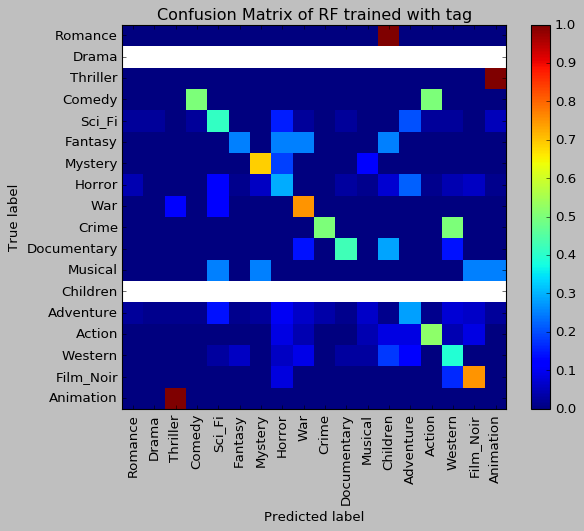

------------------------------------
Features:  tag

Logistic Regression
Train acc: 0.448
Valid acc: 0.381


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


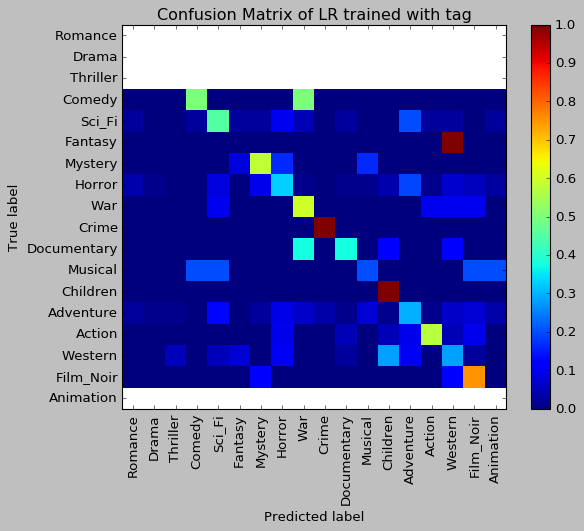

------------------------------------
Features:  tag

MLP
Train acc: 0.663
Valid acc: 0.341


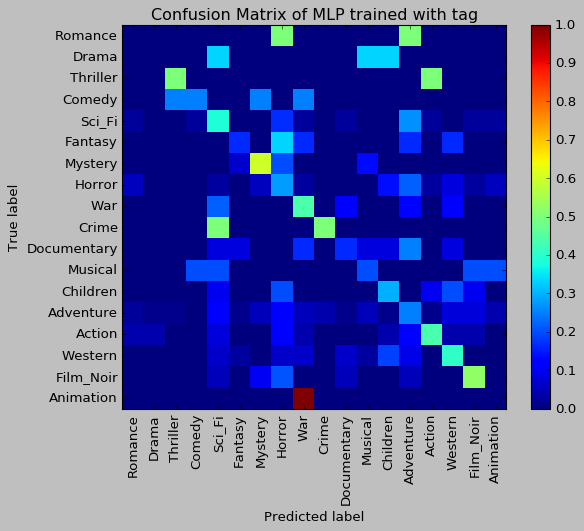

------------------------------------


In [85]:
train_X = [tf_tag]
train_y = tl
test_X = [vf_tag]
test_y = vl
fea_name = 'tag'
trainModelWithFeatures(train_X, train_y, test_X, test_y, fea_name)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Features:  title

Random Forest
Train acc: 0.99
Valid acc: 0.197


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


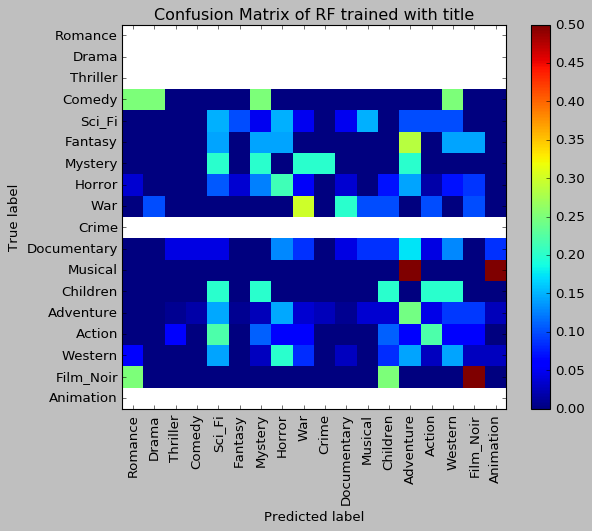

------------------------------------
Features:  title

Logistic Regression
Train acc: 0.601
Valid acc: 0.201


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


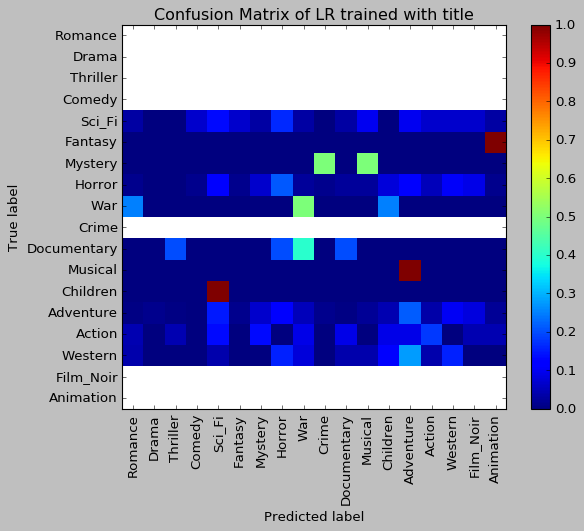

------------------------------------
Features:  title

MLP
Train acc: 0.988
Valid acc: 0.174


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


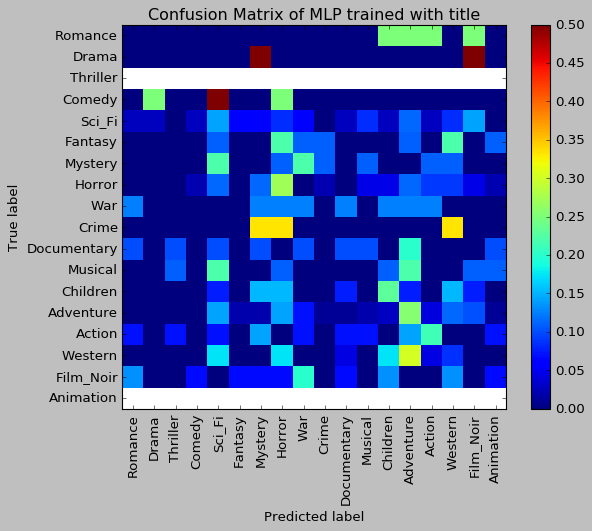

------------------------------------


In [86]:
train_X = [tf_title]
train_y = tl
test_X = [vf_title]
test_y = vl
fea_name = 'title'
trainModelWithFeatures(train_X, train_y, test_X, test_y, fea_name)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Features:  audio

Random Forest
Train acc: 1.0
Valid acc: 0.201


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


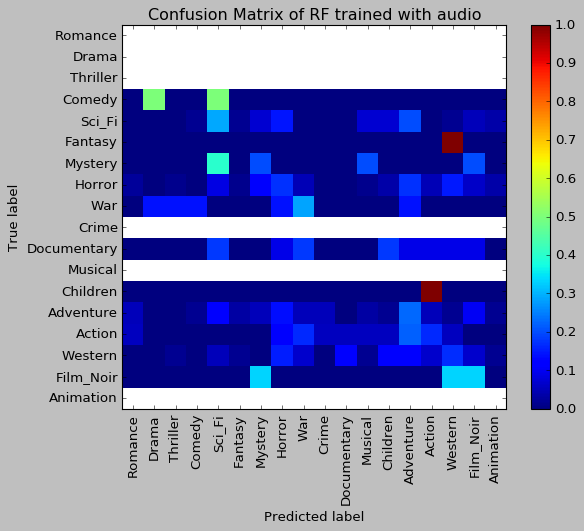

------------------------------------
Features:  audio

Logistic Regression
Train acc: 0.203
Valid acc: 0.191


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


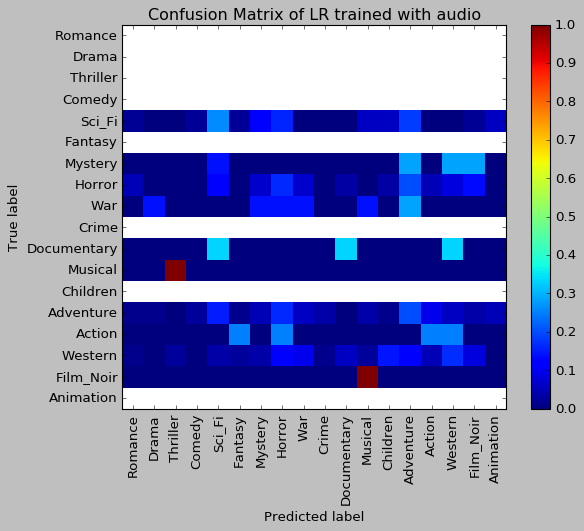

------------------------------------
Features:  audio

MLP
Train acc: 0.221
Valid acc: 0.171


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


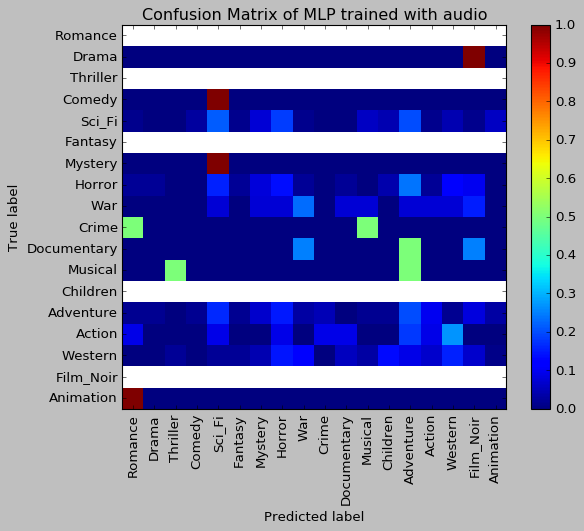

------------------------------------


In [87]:
train_X = [tf_audio]
train_y = tl
test_X = [vf_audio]
test_y = vl
fea_name = 'audio'
trainModelWithFeatures(train_X, train_y, test_X, test_y, fea_name)

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Features:  visual

Random Forest
Train acc: 0.988
Valid acc: 0.217


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


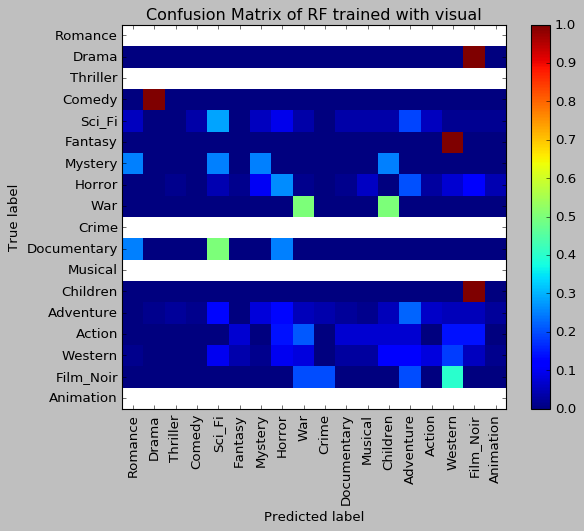

------------------------------------
Features:  visual

Logistic Regression
Train acc: 0.211
Valid acc: 0.194


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


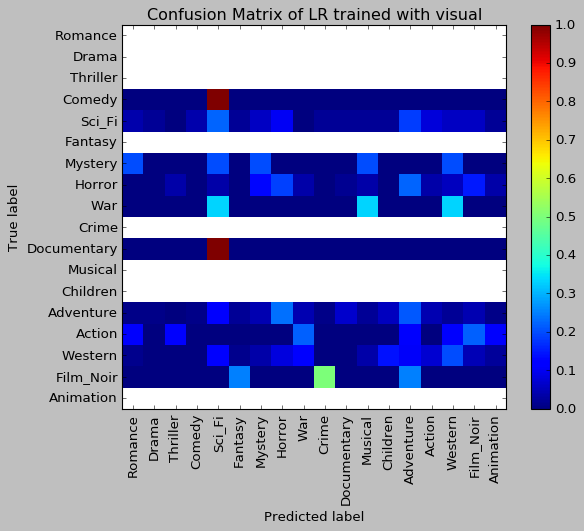

------------------------------------
Features:  visual

MLP
Train acc: 0.519
Valid acc: 0.161


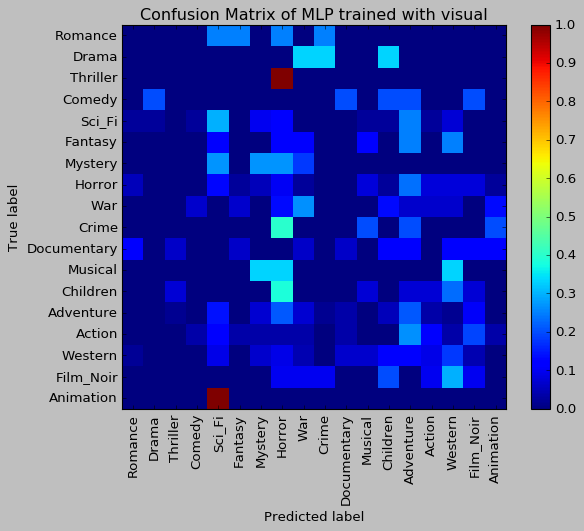

------------------------------------


In [88]:
train_X = [ tf_visual]
train_y = tl
test_X = [vf_visual]
test_y = vl
fea_name = 'visual'
trainModelWithFeatures(train_X, train_y, test_X, test_y, fea_name)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Features:  tag title

Random Forest
Train acc: 0.999
Valid acc: 0.381


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


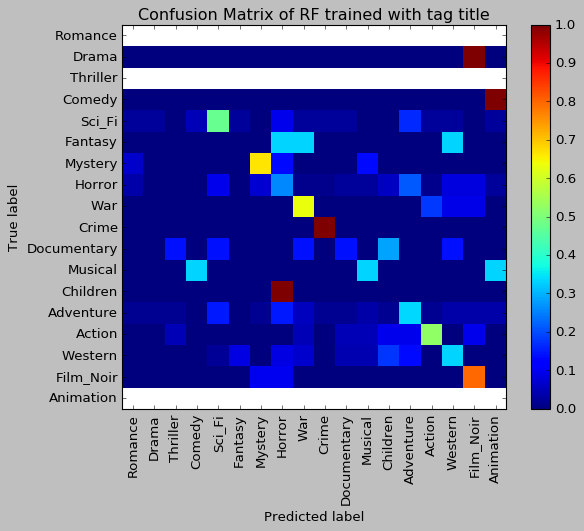

------------------------------------
Features:  tag title

Logistic Regression
Train acc: 0.695
Valid acc: 0.395


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


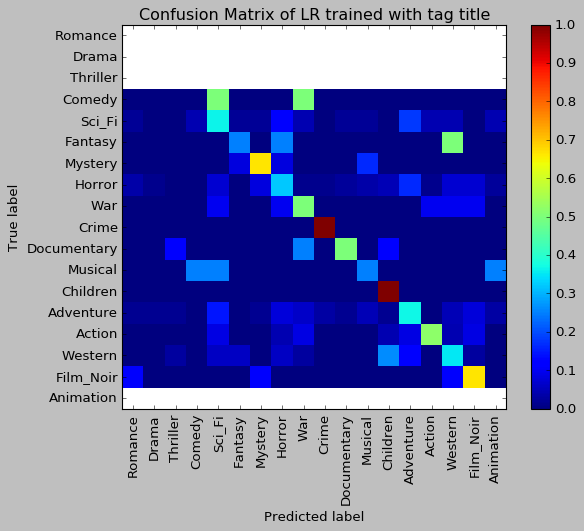

------------------------------------
Features:  tag title

MLP
Train acc: 0.999
Valid acc: 0.281


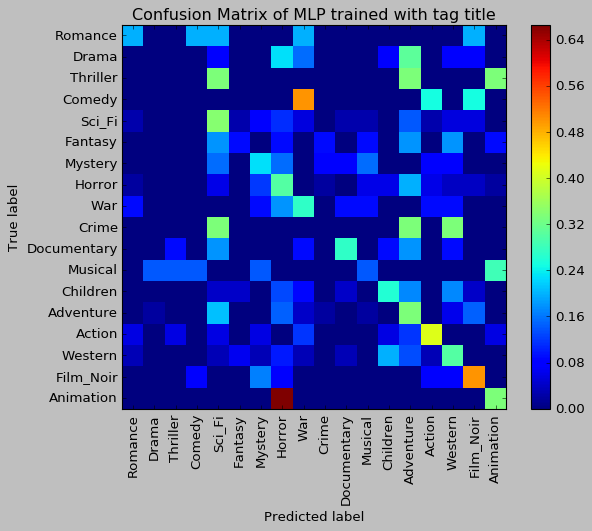

------------------------------------


In [89]:
train_X = [tf_tag, tf_title]
train_y = tl
test_X = [vf_tag, vf_title]
test_y = vl
fea_name = 'tag title'
trainModelWithFeatures(train_X, train_y, test_X, test_y, fea_name)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Features:  tag audio

Random Forest
Train acc: 1.0
Valid acc: 0.324


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


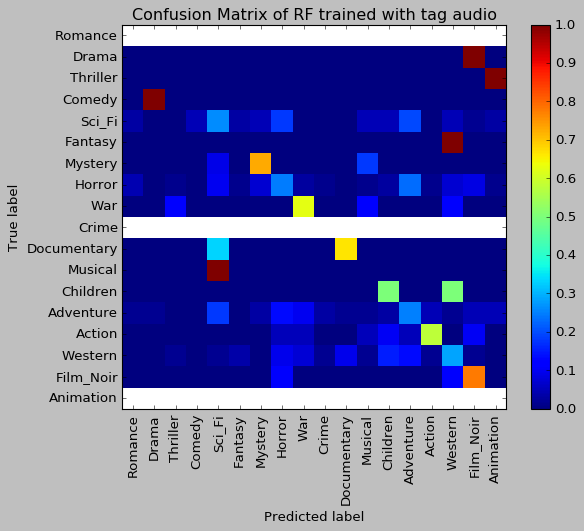

------------------------------------
Features:  tag audio

Logistic Regression
Train acc: 0.202
Valid acc: 0.181


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


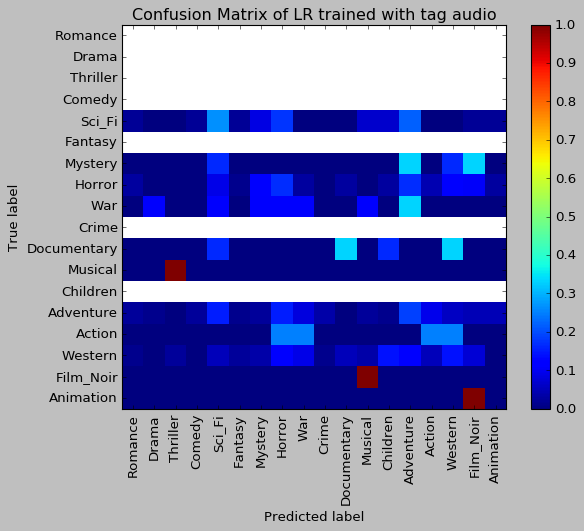

------------------------------------
Features:  tag audio

MLP
Train acc: 0.224
Valid acc: 0.214


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


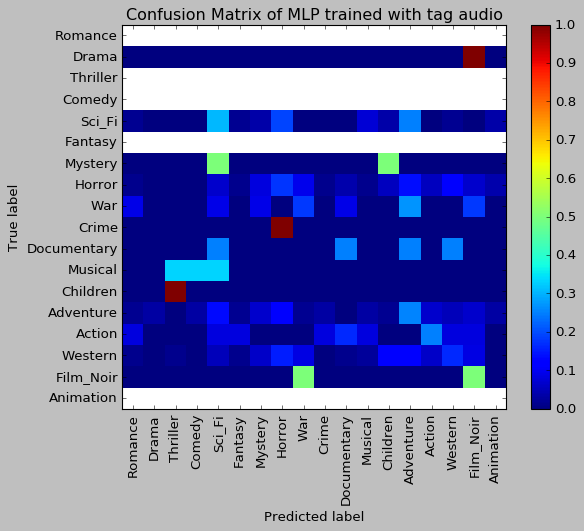

------------------------------------


In [90]:
train_X = [tf_tag, tf_audio]
train_y = tl
test_X = [vf_tag, vf_audio]
test_y = vl
fea_name = 'tag audio'
trainModelWithFeatures(train_X, train_y, test_X, test_y, fea_name)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Features:  tag visual

Random Forest
Train acc: 0.999
Valid acc: 0.378


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


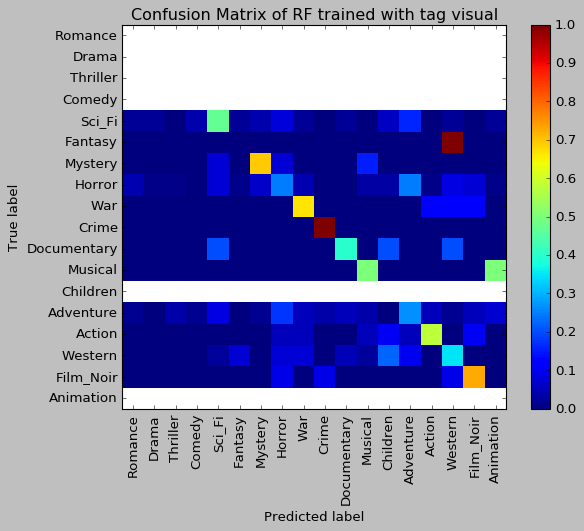

------------------------------------
Features:  tag visual

Logistic Regression
Train acc: 0.47
Valid acc: 0.391


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


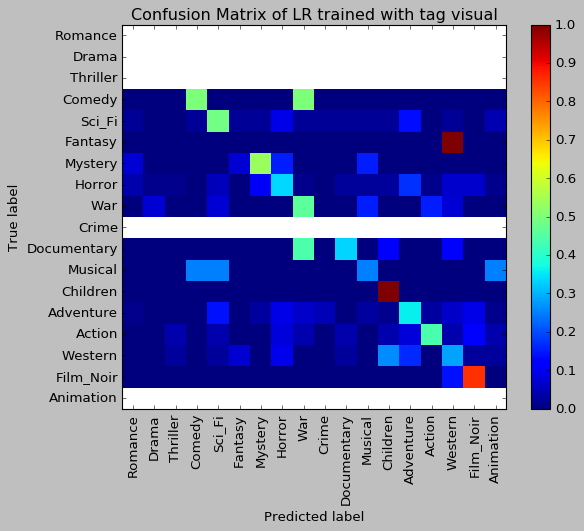

------------------------------------
Features:  tag visual

MLP
Train acc: 0.946
Valid acc: 0.318


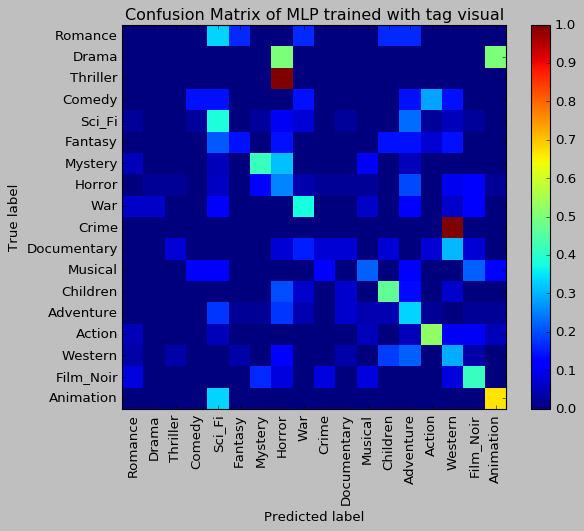

------------------------------------


In [91]:
train_X = [tf_tag, tf_visual]
train_y = tl
test_X = [vf_tag, vf_visual]
test_y = vl
fea_name = 'tag visual'
trainModelWithFeatures(train_X, train_y, test_X, test_y, fea_name)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Features:  title audio

Random Forest
Train acc: 1.0
Valid acc: 0.234


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


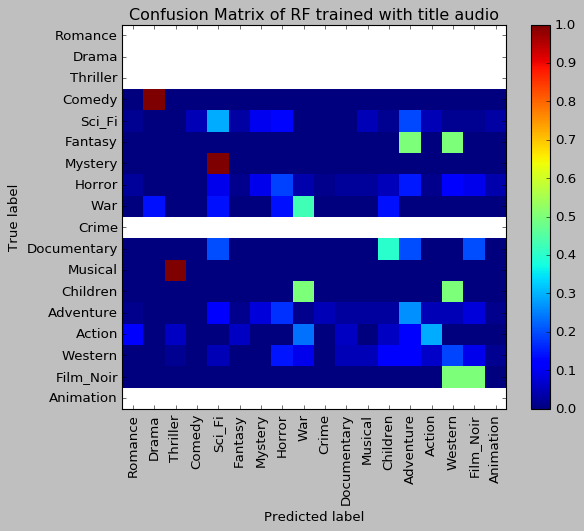

------------------------------------
Features:  title audio

Logistic Regression
Train acc: 0.2
Valid acc: 0.181


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


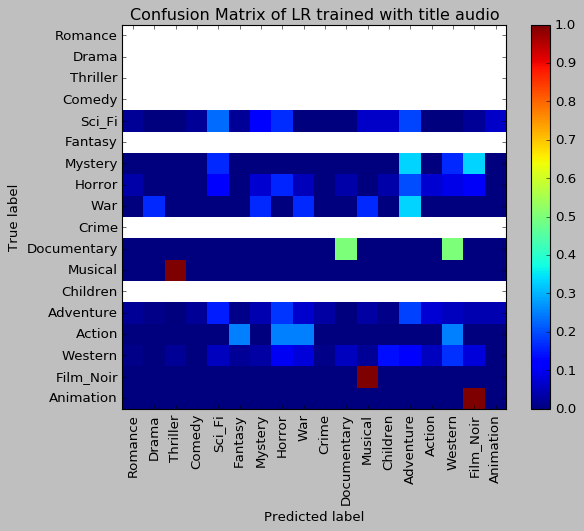

------------------------------------
Features:  title audio

MLP
Train acc: 0.218
Valid acc: 0.201


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


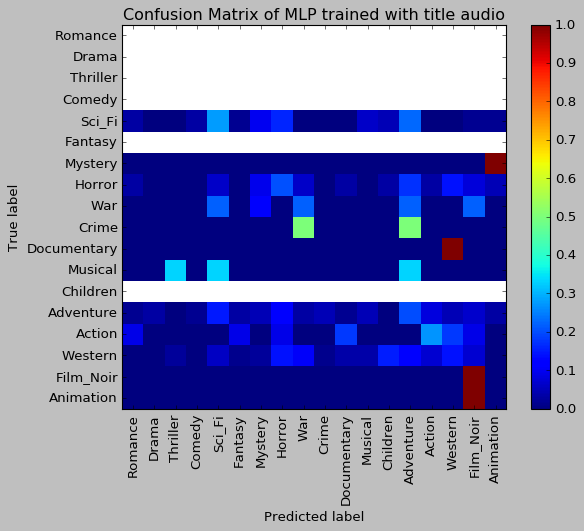

------------------------------------


In [92]:
train_X = [tf_title, tf_audio]
train_y = tl
test_X = [vf_title, vf_audio]
test_y = vl
fea_name = 'title audio'
trainModelWithFeatures(train_X, train_y, test_X, test_y, fea_name)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Features:  title visual

Random Forest
Train acc: 0.997
Valid acc: 0.234


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


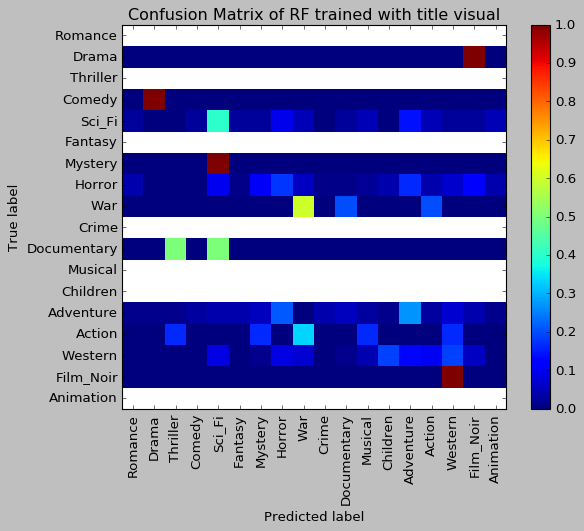

------------------------------------
Features:  title visual

Logistic Regression
Train acc: 0.602
Valid acc: 0.207


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


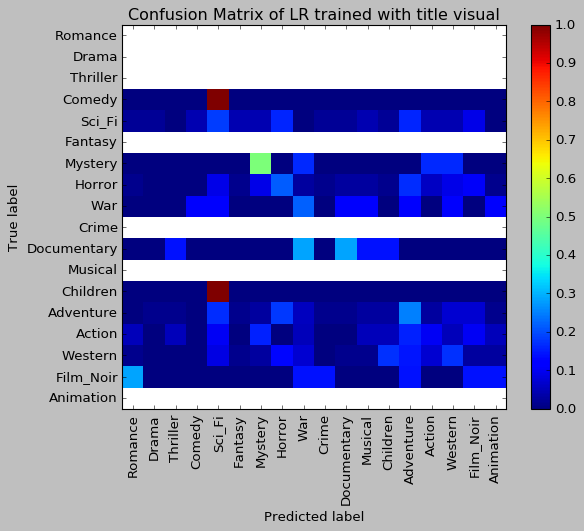

------------------------------------
Features:  title visual

MLP
Train acc: 0.997
Valid acc: 0.154


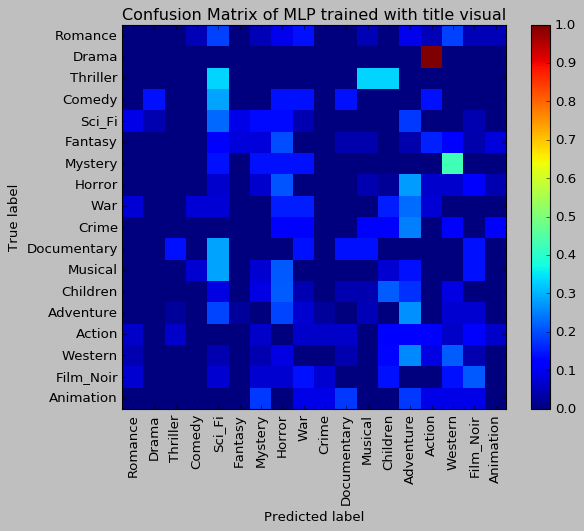

------------------------------------


In [93]:
train_X = [tf_title, tf_visual]
train_y = tl
test_X = [vf_title, vf_visual]
test_y = vl
fea_name = 'title visual'
trainModelWithFeatures(train_X, train_y, test_X, test_y, fea_name)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Features:  audio visual

Random Forest
Train acc: 1.0
Valid acc: 0.217


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


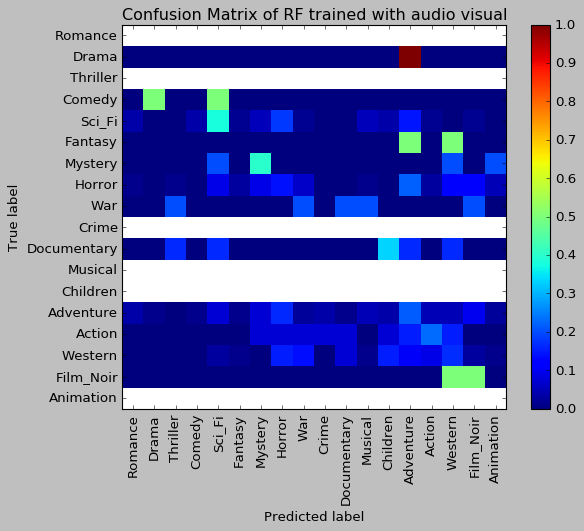

------------------------------------
Features:  audio visual

Logistic Regression
Train acc: 0.203
Valid acc: 0.181


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


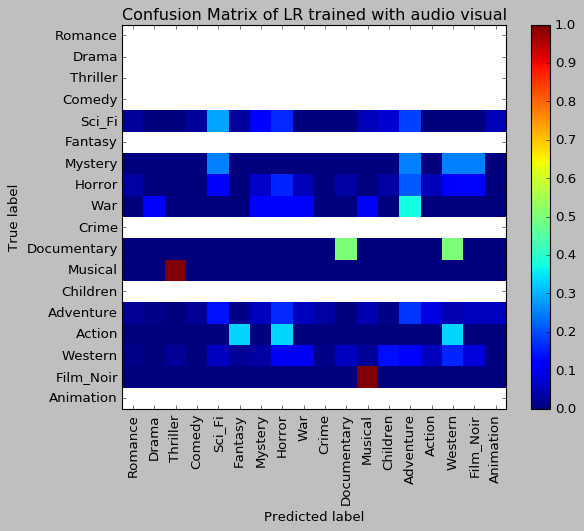

------------------------------------
Features:  audio visual

MLP
Train acc: 0.223
Valid acc: 0.194


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


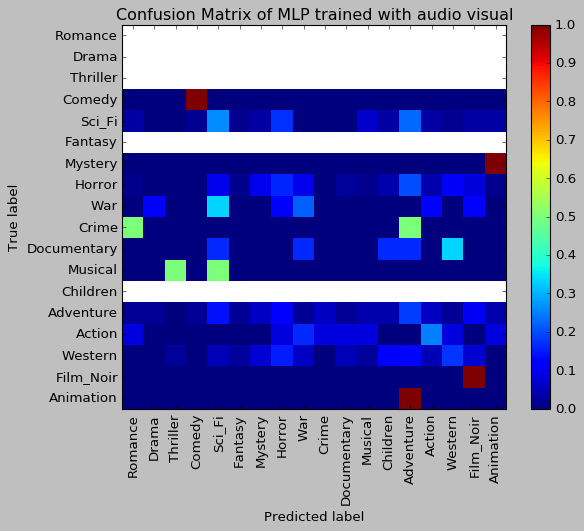

------------------------------------


In [94]:
train_X = [tf_audio, tf_visual]
train_y = tl
test_X = [vf_audio, vf_visual]
test_y = vl
fea_name = 'audio visual'
trainModelWithFeatures(train_X, train_y, test_X, test_y, fea_name)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Features:  tag title audio

Random Forest
Train acc: 1.0
Valid acc: 0.314


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


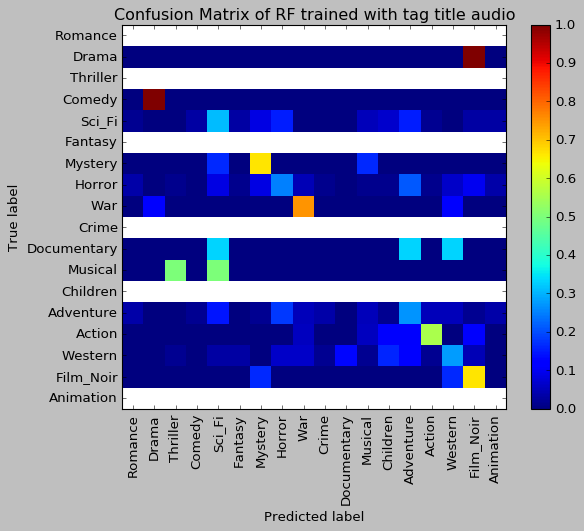

------------------------------------
Features:  tag title audio

Logistic Regression
Train acc: 0.204
Valid acc: 0.191


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


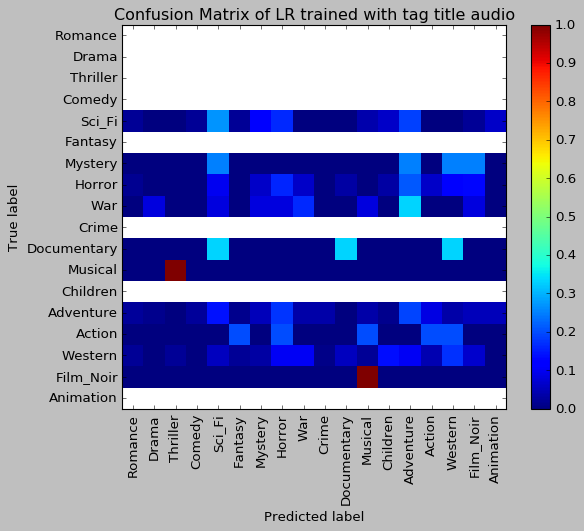

------------------------------------
Features:  tag title audio

MLP
Train acc: 0.224
Valid acc: 0.204


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


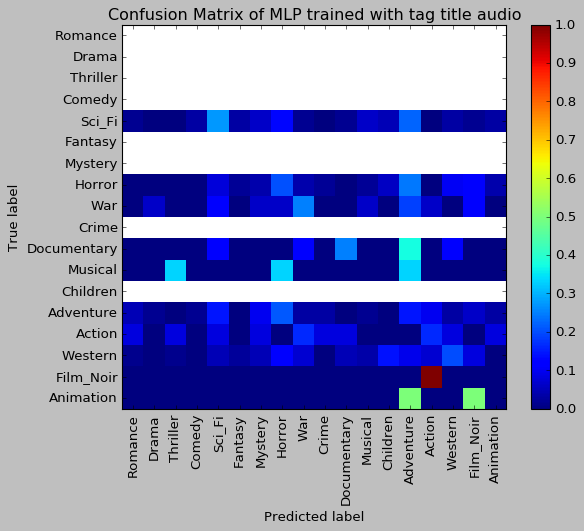

------------------------------------


In [95]:
train_X = [tf_tag, tf_title, tf_audio]
train_y = tl
test_X = [vf_tag, vf_title, vf_audio]
test_y = vl
fea_name = 'tag title audio'
trainModelWithFeatures(train_X, train_y, test_X, test_y, fea_name)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Features:  tag title visual

Random Forest
Train acc: 0.999
Valid acc: 0.371


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


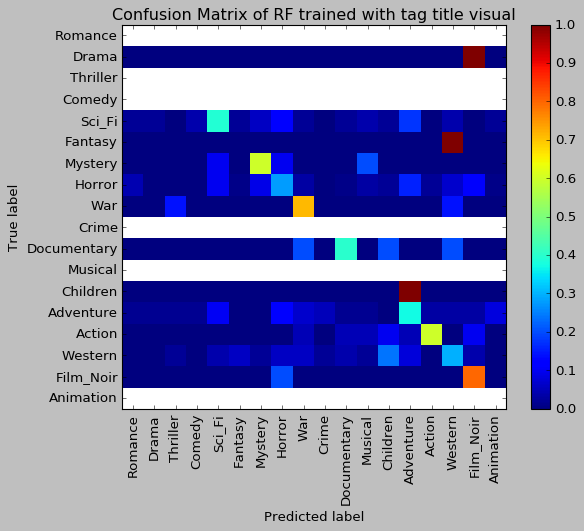

------------------------------------
Features:  tag title visual

Logistic Regression
Train acc: 0.711
Valid acc: 0.411


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


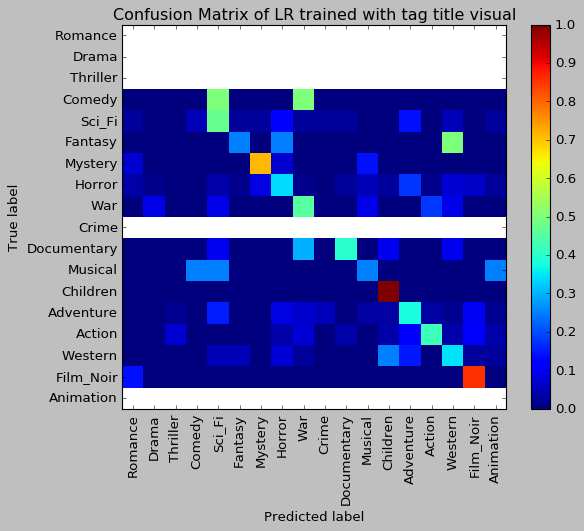

------------------------------------
Features:  tag title visual

MLP
Train acc: 0.999
Valid acc: 0.284


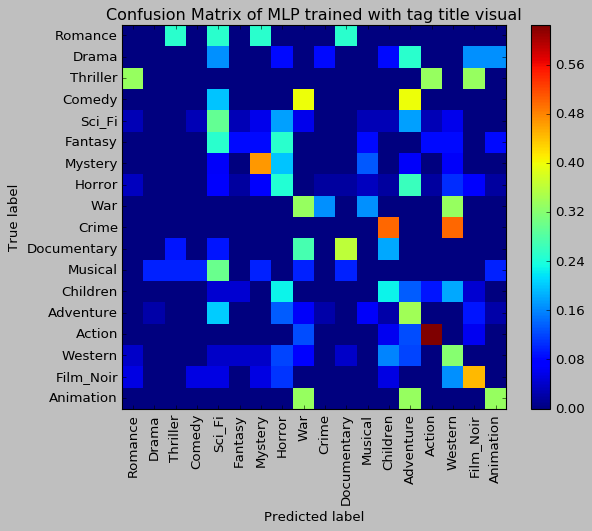

------------------------------------


In [96]:
train_X = [tf_tag, tf_title, tf_visual]
train_y = tl
test_X = [vf_tag, vf_title, vf_visual]
test_y = vl
fea_name = 'tag title visual'
trainModelWithFeatures(train_X, train_y, test_X, test_y, fea_name)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Features:  title audio visual

Random Forest
Train acc: 1.0
Valid acc: 0.187


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


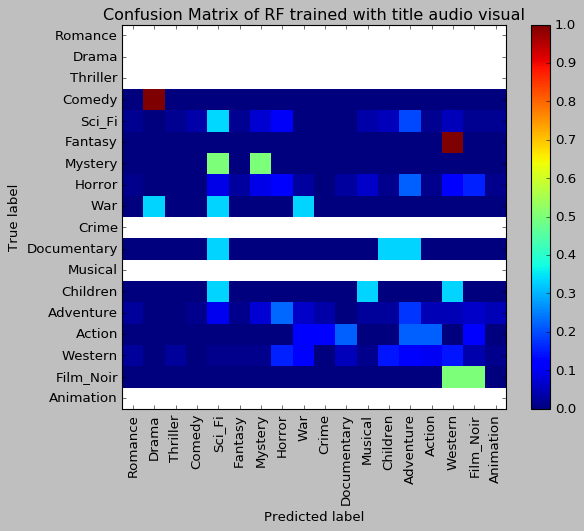

------------------------------------
Features:  title audio visual

Logistic Regression
Train acc: 0.204
Valid acc: 0.184


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


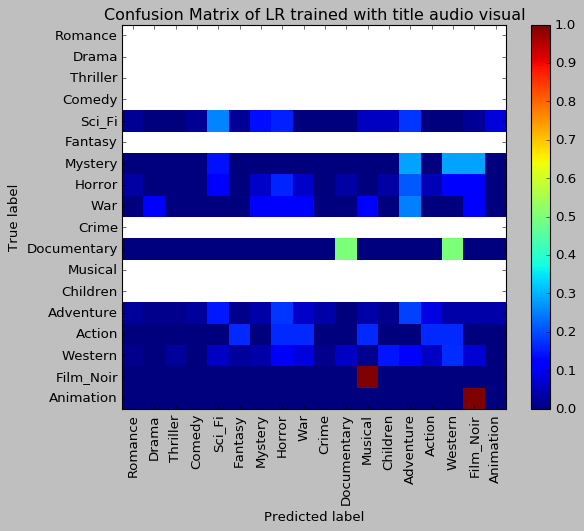

------------------------------------
Features:  title audio visual

MLP
Train acc: 0.213
Valid acc: 0.214


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


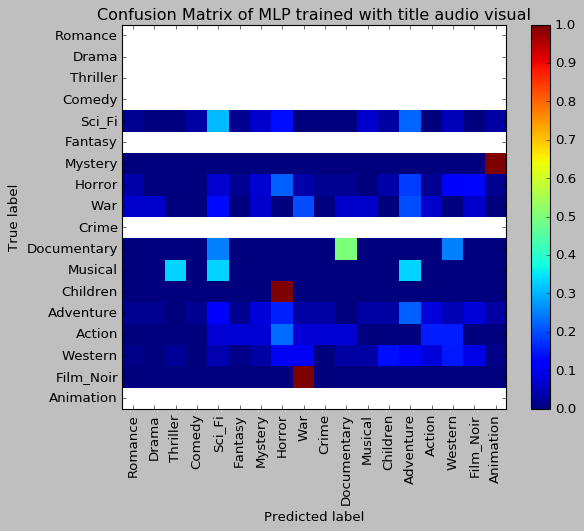

------------------------------------


In [97]:
train_X = [tf_title, tf_audio, tf_visual]
train_y = tl
test_X = [vf_title, vf_audio, vf_visual]
test_y = vl
fea_name = 'title audio visual'
trainModelWithFeatures(train_X, train_y, test_X, test_y, fea_name)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Features:  tag audio visual

Random Forest
Train acc: 1.0
Valid acc: 0.331


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


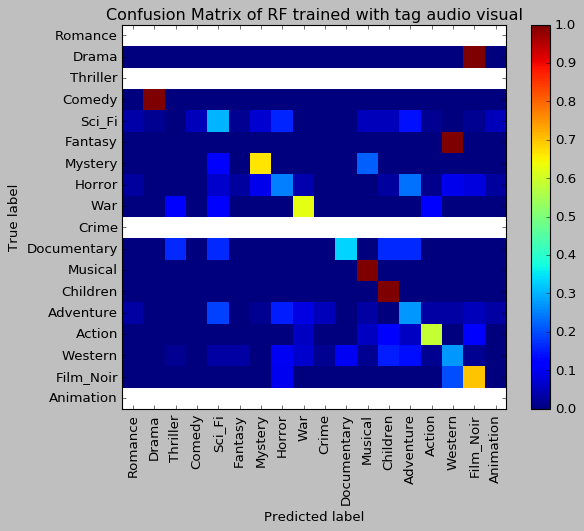

------------------------------------
Features:  tag audio visual

Logistic Regression
Train acc: 0.206
Valid acc: 0.177


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


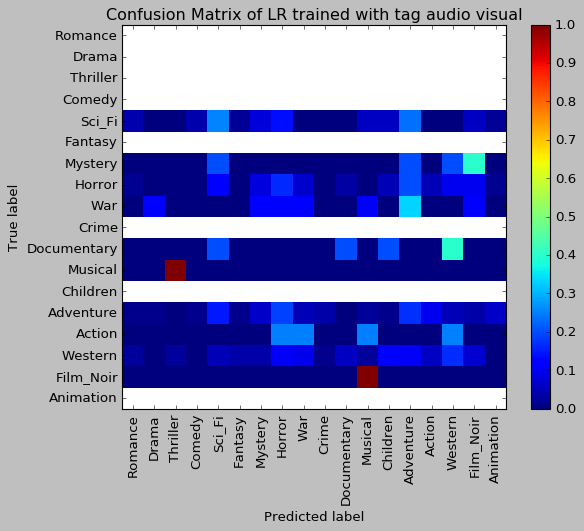

------------------------------------
Features:  tag audio visual

MLP
Train acc: 0.226
Valid acc: 0.177


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


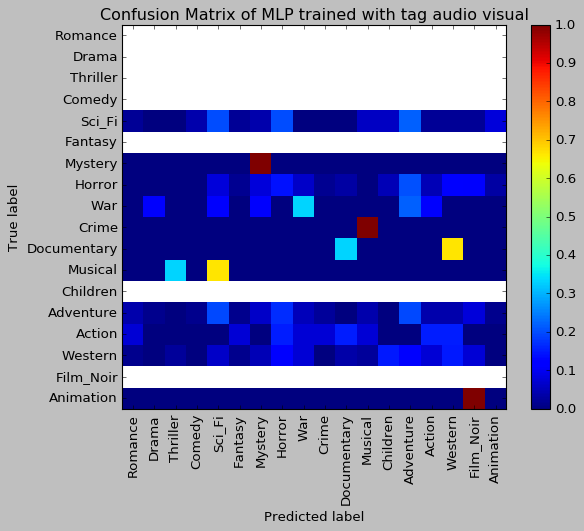

------------------------------------


In [98]:
train_X = [tf_tag, tf_audio, tf_visual]
train_y = tl
test_X = [vf_tag, vf_audio, vf_visual]
test_y = vl
fea_name = 'tag audio visual'
trainModelWithFeatures(train_X, train_y, test_X, test_y, fea_name)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Features:  tag title audio visual

Random Forest
Train acc: 1.0
Valid acc: 0.331


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


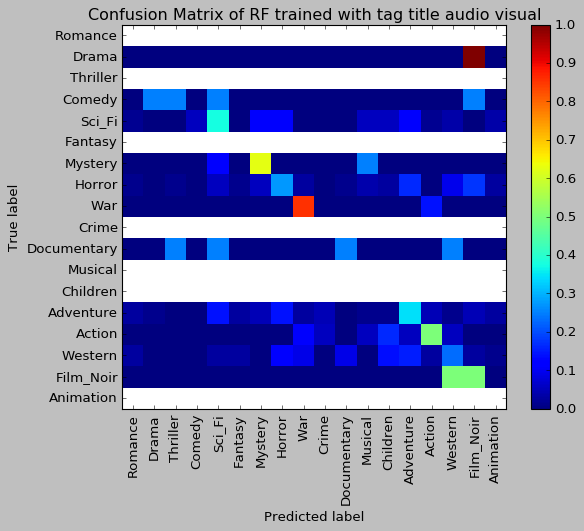

------------------------------------
Features:  tag title audio visual

Logistic Regression
Train acc: 0.199
Valid acc: 0.187


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


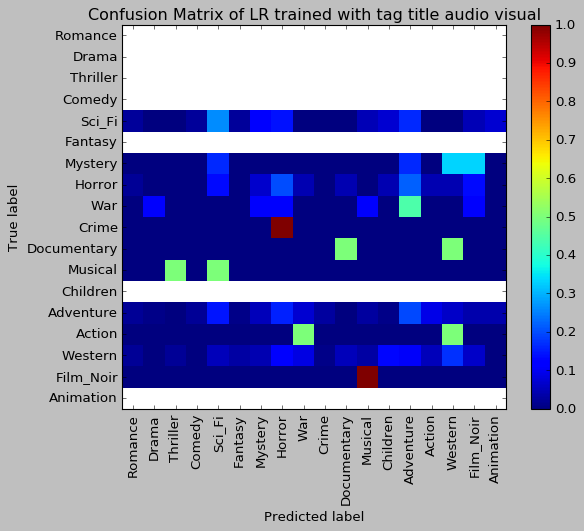

------------------------------------
Features:  tag title audio visual

MLP
Train acc: 0.219
Valid acc: 0.214


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


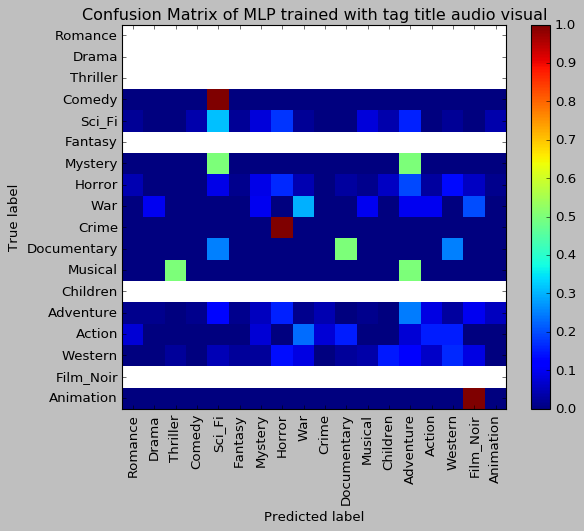

------------------------------------


In [99]:
train_X = [tf_tag, tf_title, tf_audio, tf_visual]
train_y = tl
test_X = [vf_tag, vf_title, vf_audio, vf_visual]
test_y = vl
fea_name = 'tag title audio visual'
trainModelWithFeatures(train_X, train_y, test_X, test_y, fea_name)

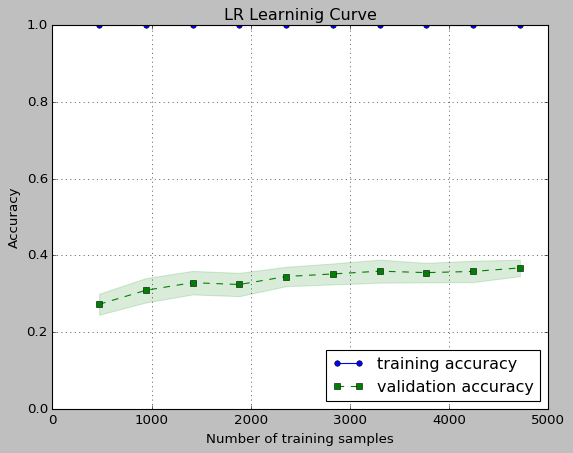

In [120]:
#generate learning curve of RF trained with tag, title and visual feature 
#on the training set, since this combination has the best performance.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(n_estimators=100, 
                                   bootstrap = True,
                                   max_features = 'sqrt')
    
train_sizes, train_scores, test_scores = learning_curve(estimator=rf,
                              X=pd.concat([tf_tag, tf_title, tf_visual],axis=1),
                              y=tl.genres,
                              train_sizes=np.linspace(0.1,1.0,10),
                              cv=10,
                              n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std,alpha=0.15,color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--',marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std,alpha=0.15,color='green')
plt.grid()
plt.title('LR Learninig Curve')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.0, 1.0])
plt.show()

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


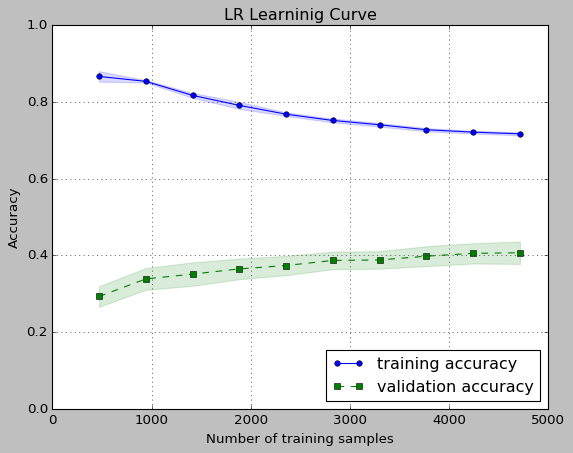

In [54]:
#generate learning curve of LR trained with tag, title and visual feature 
#on the training set, since this combination has the best performance.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression


lr = LogisticRegression(C=1.0, penalty='l2', tol=0.01)
    
train_sizes, train_scores, test_scores = learning_curve(estimator=lr,
                              X=pd.concat([tf_tag, tf_title, tf_visual],axis=1),
                              y=tl.genres,
                              train_sizes=np.linspace(0.1,1.0,10),
                              cv=10,
                              n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std,alpha=0.15,color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--',marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std,alpha=0.15,color='green')
plt.grid()
plt.title('LR Learninig Curve')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.0, 1.0])
plt.show()

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


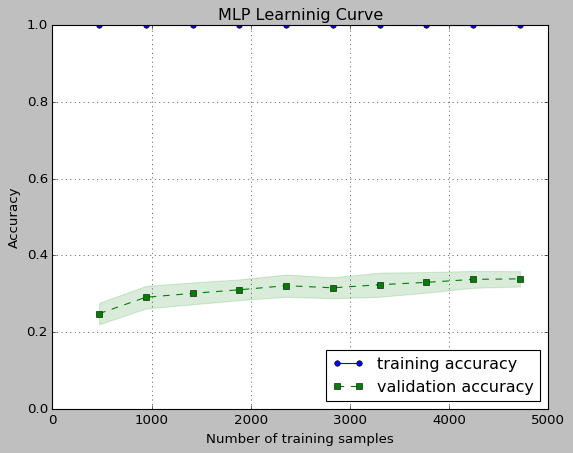

In [55]:
#generate learning curve of MLP trained with tag, title and visual feature 
#on the training set, since this combination has the best performance.import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import learning_curve
from sklearn.neural_network import MLPClassifier


mlp = MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
           beta_2=0.999, early_stopping=False, epsilon=1e-08,
           hidden_layer_sizes=(100, 100), learning_rate='constant',
           learning_rate_init=0.001, max_iter=200, momentum=0.9,
           nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
           solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
           warm_start=False)

  
train_sizes, train_scores, test_scores = learning_curve(estimator=mlp,
                              X=pd.concat([tf_tag, tf_title, tf_visual],axis=1),
                              y=tl.genres,
                              train_sizes=np.linspace(0.1,1.0,10),
                              cv=10,
                              n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std,alpha=0.15,color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--',marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std,alpha=0.15,color='green')
plt.grid()
plt.title('MLP Learninig Curve')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.0, 1.0])
plt.show()

In [116]:
from sklearn.linear_model import LogisticRegression
#pre-process the test features in the same way with train features
test = pd.read_csv('data/test_features.tsv', sep = '\t')
test = test.drop(columns = ['year', 'YTId'])

test_tag_vec = tag_vec.transform(test.tag)
test_tag = tag_trans.transform(test_tag_vec)
test_tag = pd.DataFrame(test_tag.todense())
test_tag.columns = tag_col

test_title_vec = title_vec.transform(test.title.values.astype('U'))
test_title = title_trans.transform(test_title_vec)
test_title = pd.DataFrame(test_title.todense())
test_title.columns=title_col

test_audio = test[audio_col]
test_visual = test[visual_col]

#fit the lr classifier
lr = LogisticRegression(C=1.0, penalty='l2', tol=0.01)
lr.fit(pd.concat([tf_tag, tf_title, tf_visual],axis=1),tl.genres)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.01, verbose=0,
                   warm_start=False)

In [118]:
#predict genre for movies in the test set with tag, title, visual feature
test_pred = lr.predict(pd.concat([test_tag, test_title, test_visual],axis=1))
test_pred = pd.DataFrame(test_pred)
test_pred = pd.concat([test.movieId, test_pred],axis=1)
test_pred.columns=['movieId', 'genres']
test_pred.to_csv('data/test_pred.csv', index=False)
